# 06 – Anotación de Level1 (linajes principales) y división por linaje

Notebook dedicado a:
- asignar un linaje **Level1** a cada célula,
- guardar esa anotación en `obs["Level1"]`,
- dividir el objeto global en sub-objetos por linaje,
- y calcular marcadores 1-vs-rest por Level1.

Trabaja sobre el objeto global con Harmony, vecinos, UMAP y clustering Leiden.

## 1. Contexto: ¿qué es Level1 y cómo se anota?

- **Level1** = linajes principales (macro-clases):  
  `T_and_NK`, `B`, `Plasma`, `Mono_and_DC`, `pDC`, `Platelets`, `RBC_and_HSC`, `ILC`, `UTC`.
- Fuentes conceptuales:
  - `markers/markers.py` → `geneMarkers_level1` (paneles ejecutables para el código).
  - `summaries/atlas_notas.md` → guía textual y reglas de decisión.
- Estrategia general:
  - partir del clustering global `leiden_L1`,
  - usar paneles de marcadores de Level1,
  - proponer y aplicar una etiqueta `Level1` por cluster,
  - dividir el objeto en un archivo `.h5ad` por linaje.

In [1]:
### Celda 3 — Código: importación de librerías

from pathlib import Path
import json

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

print("Scanpy:", sc.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.11.5
AnnData: 0.12.6


C:\Users\Coni\AppData\Local\Temp\ipykernel_15168\4085009592.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Scanpy:", sc.__version__)
C:\Users\Coni\AppData\Local\Temp\ipykernel_15168\4085009592.py:12: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  print("AnnData:", ad.__version__)


## 2. Organización de carpetas y configuración básica

- Se definen rutas:
  - `AI_PACKAGE_DIR`, `MARKERS_DIR`, `SUMMARIES_DIR`,
  - `DATA_PROCESSED_DIR`, `LINEAGES_DIR`.
- Se lee `MANIFEST.json` (si existe) para recuperar:
  - `EMB_KEY` (embedding Harmony),
  - `NBR_KEY` (neighbors),
  - `UMAP_KEY` (UMAP integrado).
- Entrada configurada en:
  - `HARMONY_NEIGH_UMAP_H5AD_PATH = data_processed/TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad`.
- Salidas:
  - `TFM_CIRRHOSIS_main_with_Level1.h5ad`,
  - `data_processed/lineages/TFM_CIRRHOSIS_Level1_<LINAGE>.h5ad`.

In [2]:
# Detectamos la carpeta raíz del proyecto asumiendo que este notebook está en "notebooks/"
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

AI_PACKAGE_DIR      = PROJECT_ROOT / "AI_Package"
MARKERS_DIR         = AI_PACKAGE_DIR / "markers"
SUMMARIES_DIR       = AI_PACKAGE_DIR / "summaries"
DATA_RAW_DIR        = PROJECT_ROOT / "data_raw"
DATA_PROCESSED_DIR  = PROJECT_ROOT / "data_processed"
LINEAGES_DIR        = DATA_PROCESSED_DIR / "lineages"
DATA_PROCESSED_DIR.mkdir(exist_ok=True)
LINEAGES_DIR.mkdir(exist_ok=True)

print("Directorio del notebook:", NOTEBOOK_DIR)
print("Raíz del proyecto:", PROJECT_ROOT)
print("Carpeta AI_Package:", AI_PACKAGE_DIR)
print("Carpeta markers:", MARKERS_DIR)
print("Carpeta summaries:", SUMMARIES_DIR)
print("Carpeta data_processed:", DATA_PROCESSED_DIR)
print("Carpeta lineages:", LINEAGES_DIR)

# Leemos MANIFEST.json para recuperar claves estándar
manifest_path = AI_PACKAGE_DIR / "MANIFEST.json"
if manifest_path.exists():
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
else:
    manifest = {}
    print("\n[AVISO] No se ha encontrado MANIFEST.json; se usarán valores por defecto.")

EMB_KEY = manifest.get("keys", {}).get("EMB_KEY", "X_pca_harmony")
NBR_KEY = manifest.get("keys", {}).get("NBR_KEY", "harmony")
UMAP_KEY = manifest.get("keys", {}).get("UMAP_KEY", "X_umap_harmony")

CONFIG = {
    "PROJECT_ROOT": PROJECT_ROOT,
    "AI_PACKAGE_DIR": AI_PACKAGE_DIR,
    "MARKERS_DIR": MARKERS_DIR,
    "SUMMARIES_DIR": SUMMARIES_DIR,
    "DATA_PROCESSED_DIR": DATA_PROCESSED_DIR,
    "LINEAGES_DIR": LINEAGES_DIR,
    # Usamos el objeto con Harmony + vecinos + UMAP completo (sin sufijo HVGsubset)
    "HARMONY_NEIGH_UMAP_H5AD_PATH": DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad",
    "EMB_KEY": EMB_KEY,
    "NBR_KEY": NBR_KEY,
    "UMAP_KEY": UMAP_KEY,
}

CONFIG

Directorio del notebook: D:\Users\Coni\Documents\TFM_CirrhosIS\notebooks
Raíz del proyecto: D:\Users\Coni\Documents\TFM_CirrhosIS
Carpeta AI_Package: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package
Carpeta markers: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package\markers
Carpeta summaries: D:\Users\Coni\Documents\TFM_CirrhosIS\AI_Package\summaries
Carpeta data_processed: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed
Carpeta lineages: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages


{'PROJECT_ROOT': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS'),
 'AI_PACKAGE_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package'),
 'MARKERS_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package/markers'),
 'SUMMARIES_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/AI_Package/summaries'),
 'DATA_PROCESSED_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed'),
 'LINEAGES_DIR': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/lineages'),
 'HARMONY_NEIGH_UMAP_H5AD_PATH': WindowsPath('D:/Users/Coni/Documents/TFM_CirrhosIS/data_processed/TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad'),
 'EMB_KEY': 'X_pca_harmony',
 'NBR_KEY': 'harmony',
 'UMAP_KEY': 'X_umap_harmony'}

## 3. Importación de paneles de marcadores de Level1

- Se importa `markers.py` desde `AI_Package/markers/`.
- Se extrae `geneMarkers_level1 = markers.geneMarkers_level1`, que define:
  - claves Level1 canónicas,
  - lista de genes marcadores por linaje.
- Estos paneles se usan para:
  - construir dotplots,
  - hacer scoring automático de linajes,
  - interpretar los clusters de `leiden_L1`.

In [3]:
# 3. Importación de paneles de marcadores de Level1

import sys

# Añadimos la carpeta markers al path de Python para poder importar markers.py
if str(MARKERS_DIR) not in sys.path:
    sys.path.insert(0, str(MARKERS_DIR))

try:
    import markers  # markers.py
except ImportError as e:
    raise ImportError(
        f"No se pudo importar 'markers.py' desde {MARKERS_DIR}.\n"
        f"Error original: {e}"
    )

# Extraemos el diccionario de marcadores de Level1
geneMarkers_level1 = markers.geneMarkers_level1

print("Linajes Level1 definidos en geneMarkers_level1:")
for k in geneMarkers_level1.keys():
    print(f"- {k}")

# Mostramos los paneles de marcadores de Level1
for l1, genes in geneMarkers_level1.items():
    print(f"\nLevel1 = {l1}")
    print(" Marcadores:", ", ".join(genes))

Linajes Level1 definidos en geneMarkers_level1:
- B
- Plasma
- Mono_and_DC
- pDC
- T_and_NK
- UTC
- ILC
- Platelets
- RBC_and_HSC

Level1 = B
 Marcadores: MS4A1, CD79A, CD19, TCL1A, FCER2

Level1 = Plasma
 Marcadores: MZB1, JCHAIN, XBP1, SDC1, PRDM1, IRF4

Level1 = Mono_and_DC
 Marcadores: LYZ, CST3, CD14, FCGR3A, CLEC9A, CD1C

Level1 = pDC
 Marcadores: IL3RA, LILRA4, IRF7, IRF8, GZMB, JCHAIN

Level1 = T_and_NK
 Marcadores: CD3D, CD4, CD8A, NKG7, GNLY, KLRD1

Level1 = UTC
 Marcadores: TMSB10, MALAT1, RPL13A

Level1 = ILC
 Marcadores: KIT, NCR1, KLRG1

Level1 = Platelets
 Marcadores: PPBP, PF4, NRGN

Level1 = RBC_and_HSC
 Marcadores: HBA1, HBB, CD34, KIT


## 4. Carga del objeto con neighbors + UMAP + clustering

- Se carga:
  - `TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad` desde `data_processed/`.
- Se comprueba que el objeto contiene:
  - embedding Harmony (`obsm[EMB_KEY]`, p.ej. `"X_pca_harmony"`),
  - grafo de vecinos (`uns[NBR_KEY]`),
  - UMAP (`obsm[UMAP_KEY]`),
  - clustering global `obs["leiden_L1"]`.
- Se fuerza `adata.X` a la matriz log-normalizada:
  - si existe, se usa `adata.layers["log1p_10k"]`.
- Para mapear marcadores:
  - se asegura una columna `var["symbol"]` (a partir de `var["features"]` o `var_names`),
  - se usan helpers de `markers.py` (`symbols_to_varnames`) para obtener genes realmente presentes,
  - se construye `varnames_level1 = {Level1: [genes_en_var]}`.

In [4]:
# 4. Carga del objeto con neighbors + UMAP + clustering

h5ad_path = CONFIG["HARMONY_NEIGH_UMAP_H5AD_PATH"]

if not h5ad_path.exists():
    raise FileNotFoundError(
        f"No se encuentra el archivo con neighbors+UMAP+clustering en:\n{h5ad_path}\n"
        "Asegúrate de que has ejecutado el notebook anterior o ajusta la ruta."
    )

adata = sc.read_h5ad(h5ad_path)
print(adata)

# Aseguramos que adata.X contiene la matriz log-normalizada (log1p_10k)
BASE_LAYER = "log1p_10k"

if BASE_LAYER in adata.layers:
    print(f"Usando la capa '{BASE_LAYER}' como matriz base (copiada a adata.X).")
    X_layer = adata.layers[BASE_LAYER]
    if hasattr(X_layer, "copy"):
        adata.X = X_layer.copy()
    else:
        adata.X = np.array(X_layer, copy=True)
else:
    print(
        f"[AVISO] No se encontró la capa '{BASE_LAYER}'. "
        "Se usará adata.X tal y como viene del archivo; asegúrate de que está log-normalizada."
    )

# Comprobamos que están presentes las claves esperadas
required_obsm = [CONFIG["EMB_KEY"], CONFIG["UMAP_KEY"]]
for key in required_obsm:
    if key not in adata.obsm.keys():
        raise KeyError(f"No se encontró '{key}' en adata.obsm.")

if "leiden_L1" not in adata.obs.columns:
    raise KeyError("No se encontró 'leiden_L1' en adata.obs. Revisa el notebook de clustering global.")

print("\nResumen de Level1 clustering provisional:")
print(adata.obs["leiden_L1"].value_counts().sort_index())

# Aseguramos columna 'symbol' para poder mapear marcadores
if "symbol" not in adata.var.columns:
    if "features" in adata.var.columns:
        adata.var["symbol"] = adata.var["features"].astype(str)
    else:
        adata.var["symbol"] = adata.var_names.astype(str)

# Construimos diccionario Level1 -> var_names realmente presentes en el objeto
varnames_level1 = {}
for l1, genes in geneMarkers_level1.items():
    varnames = markers.symbols_to_varnames(adata, genes)
    varnames_level1[l1] = varnames
    print(f"\nLevel1 = {l1}")
    print(f"  Genes del panel: {', '.join(genes)}")
    print(f"  Genes encontrados en var_names: {', '.join(varnames) if varnames else '[ninguno]'}")

AnnData object with n_obs × n_vars = 225944 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'gem_id', 'patientID', 'age', 'sex', 'diagnostic', 'disease', 'disease_classification', 'disease_status', 'disease_grade', 'alternative_classification', 'comorbidity', 'sample_collection', 'scrublet_doublet_scores', 'scrublet_predicted_doublet', 'total_counts_from_X', 'n_genes_from_X', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_r0_2', 'leiden_r0_5', 'leiden_r0_8', 'leiden_L1'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'X_umap_harmony

## 5. Exploración visual de clusters globales

- Paso exploratorio (no modifica datos):
  - visualizar el UMAP integrado coloreado por `leiden_L1`,
  - y por metadatos relevantes (batch, disease, etc., si se desea).
- Objetivo:
  - comprobar que la estructura global y la integración son razonables,
  - ver dónde podrían estar los grandes linajes inmunes.

Variables que colorearán el UMAP: ['leiden_L1', 'gem_id', 'disease']


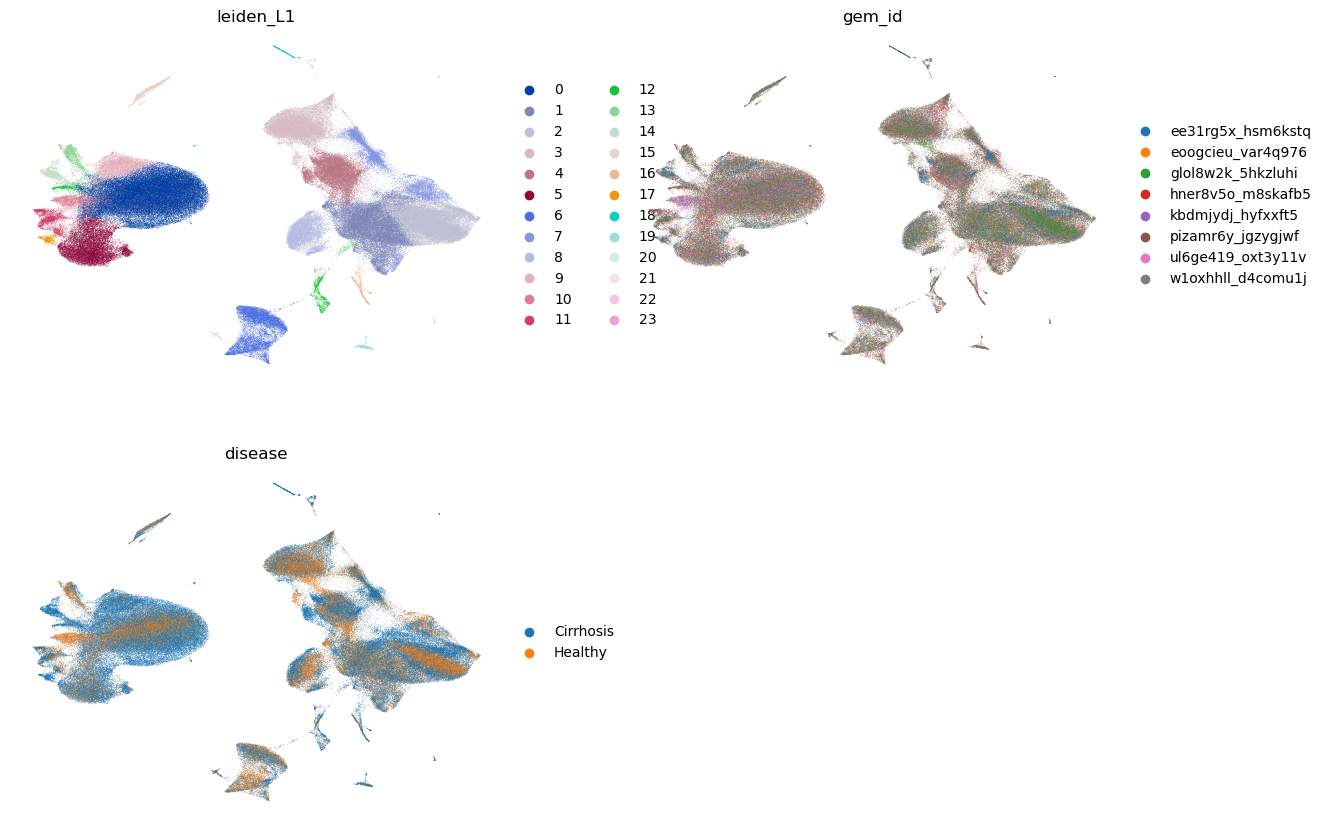

In [5]:
# 5. Exploración visual de clusters globales

# Detectamos columnas potencialmente interesantes para colorear (incluimos gem_id)
available_obs = list(adata.obs.columns)

batch_key = None
if "gem_id" in adata.obs.columns and adata.obs["gem_id"].nunique() > 1:
    batch_key = "gem_id"
elif "libraryID" in adata.obs.columns and adata.obs["libraryID"].nunique() > 1:
    batch_key = "libraryID"
elif "sample" in adata.obs.columns and adata.obs["sample"].nunique() > 1:
    batch_key = "sample"
elif "sample_id" in adata.obs.columns and adata.obs["sample_id"].nunique() > 1:
    batch_key = "sample_id"
elif "batch" in adata.obs.columns and adata.obs["batch"].nunique() > 1:
    batch_key = "batch"
elif "patientID" in adata.obs.columns and adata.obs["patientID"].nunique() > 1:
    batch_key = "patientID"

color_vars = ["leiden_L1"]
if batch_key is not None:
    color_vars.append(batch_key)

for col in ["disease", "condition", "group"]:
    if col in available_obs:
        color_vars.append(col)

print("Variables que colorearán el UMAP:", color_vars)

sc.pl.embedding(
    adata,
    basis=CONFIG["UMAP_KEY"],
    color=color_vars,
    ncols=2,
    frameon=False,
)

## 6. Dotplots de marcadores de Level1 por cluster global

- Se generan dotplots con:
  - `groupby = "leiden_L1"`,
  - `var_names = varnames_level1` (paneles de Level1 presentes en el objeto),
  - `standard_scale="var"`, `dendrogram=True`.
- Interpretación:
  - ver qué clusters expresan marcadores T_and_NK, B, Mono_and_DC, Plasma, pDC,
    Platelets, RBC_and_HSC, etc.
  - detectar clusters mixtos o poco definidos.
- Estos gráficos sirven de apoyo a la asignación de linajes.

categories: 0, 1, 2, etc.
var_group_labels: B, Plasma, Mono_and_DC, etc.


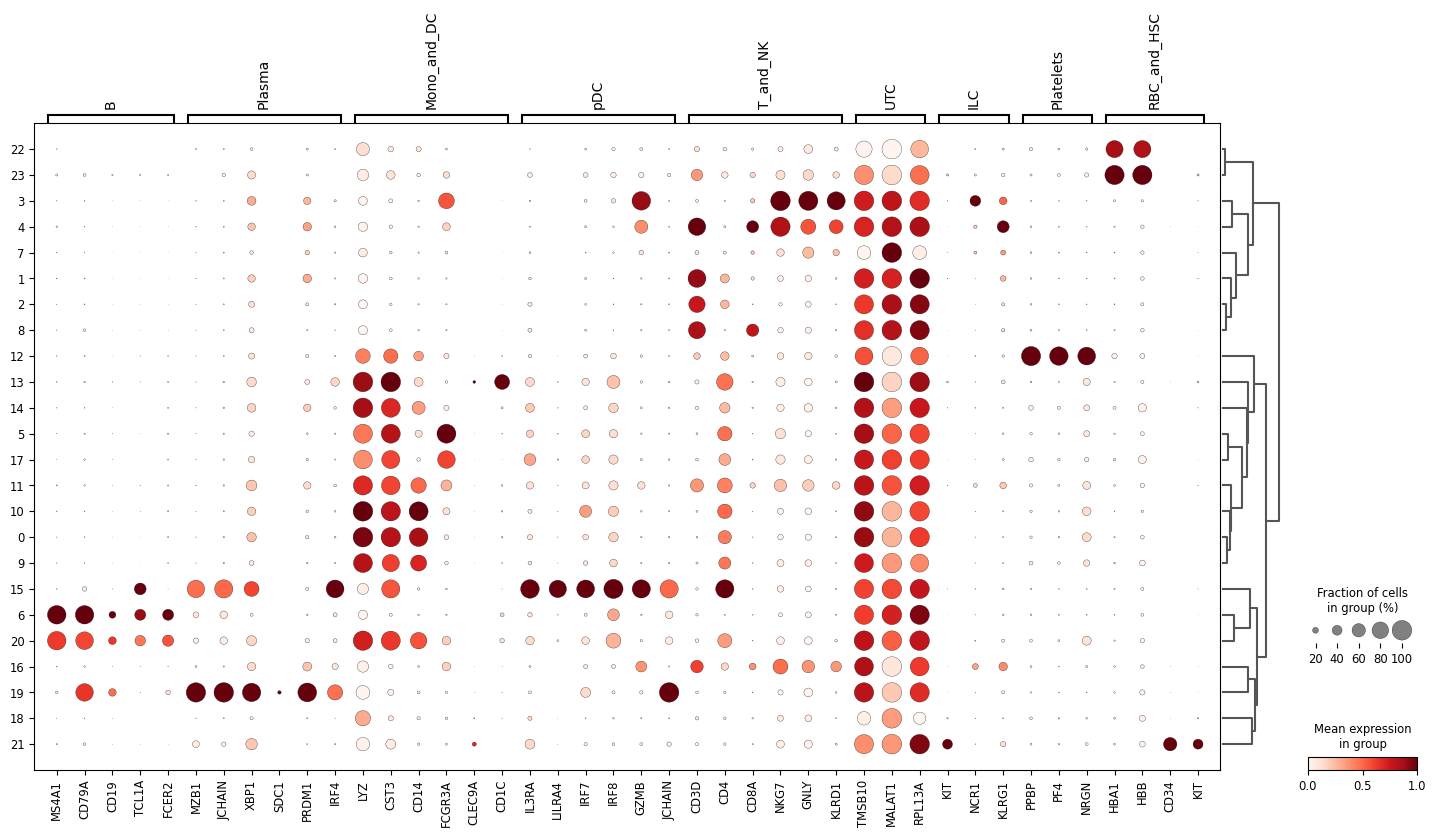

In [6]:
# 6. Dotplots de marcadores de Level1 por cluster global

# Usamos el diccionario varnames_level1 (genes realmente presentes)
# groupby = "leiden_L1" (clusters globales)

sc.pl.dotplot(
    adata,
    var_names=varnames_level1,
    groupby="leiden_L1",
    standard_scale="var",  # escala genes para facilitar lectura
    dendrogram=True,
)

## 7. (Opcional) Sugerencias automáticas de Level1 por cluster

- Se calcula una **sugerencia automática** de Level1 por cluster:

  1. Media de expresión por gen y cluster (usando `adata.X = log1p_10k`).
  2. Media del **panel** de cada Level1 para cada cluster.
  3. Se excluye explícitamente el panel `UTC` del scoring:
     - sus genes (TMSB10, MALAT1, RPL13A, …) son muy ubiquitarios.
  4. Para cada cluster, se elige el Level1 con mayor media de panel
     → `Level1_auto_suggested`.

- La columna `obs["Level1_auto_suggested"]`:
  - es solo apoyo visual,
  - se puede comparar con `leiden_L1` en el UMAP integrado.

Panel scores (media de expresión de cada panel Level1 por cluster, excluyendo UTC):
Conteo de Level1_auto_suggested (sin UTC en el scoring):
Level1_auto_suggested
T_and_NK       119362
Mono_and_DC     88902
B               12110
Platelets        2619
pDC              1876
Plasma            608
RBC_and_HSC       467
Name: count, dtype: int64


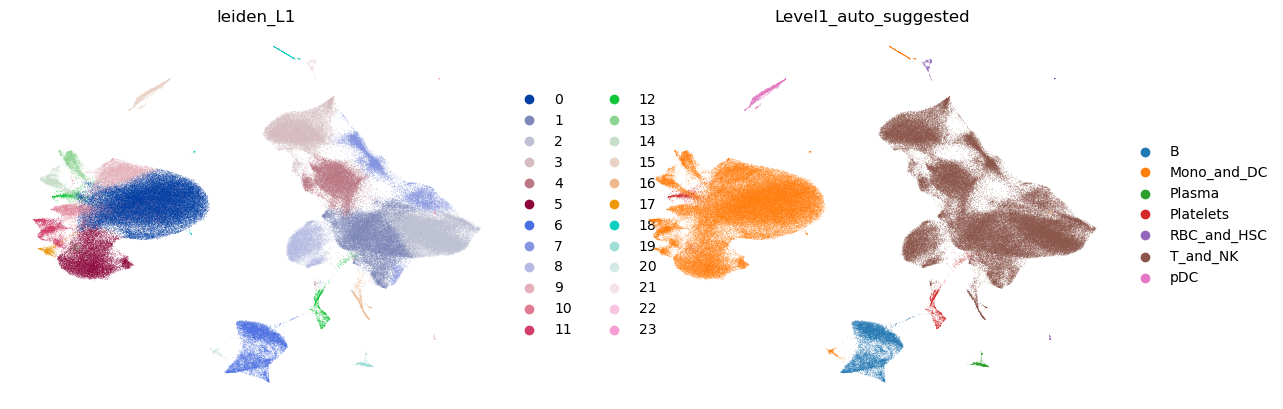

In [7]:
# 7. (Opcional) Sugerencias automáticas de Level1 por cluster

from collections import defaultdict

cluster_key = "leiden_L1"

# Calculamos la media de expresión de cada gen por cluster
# Usamos la capa actual (adata.X, normalizada y log-transformada)
clusters = adata.obs[cluster_key].astype(str)
unique_clusters = clusters.unique()

# DataFrame con medias por gen y cluster
expr_means = pd.DataFrame(
    index=adata.var_names,
    columns=unique_clusters,
    dtype=float
)

for cl in unique_clusters:
    mask = (clusters == cl).values
    X_sub = adata.X[mask]

    # media por gen dentro del cluster cl, sin densificar innecesariamente
    expr_means[cl] = np.asarray(X_sub.mean(axis=0)).ravel()

# ----------------------------------------------------------------------
# IMPORTANTE: excluimos el panel de UTC del scoring automático.
# Los genes de UTC (TMSB10, MALAT1, RPL13A) son muy ubiquitarios y si
# compiten en el scoring tienden a etiquetar casi todos los clusters como UTC.
# Lo utilizaremos solo como posible etiqueta de fallback más adelante.
# ----------------------------------------------------------------------
level1_for_scoring = [l1 for l1 in varnames_level1.keys() if l1 != "UTC"]

# Para cada cluster y cada panel de Level1 (sin UTC) calculamos la media de panel
panel_scores = pd.DataFrame(
    index=unique_clusters,
    columns=level1_for_scoring,
    dtype=float
)

for l1 in level1_for_scoring:
    varnames = varnames_level1[l1]
    genes_present = [g for g in varnames if g in expr_means.index]
    if not genes_present:
        continue
    # media de expresión del panel L1 en cada cluster (media de los genes del panel)
    panel_scores[l1] = expr_means.loc[genes_present].mean(axis=0)

print("Panel scores (media de expresión de cada panel Level1 por cluster, excluyendo UTC):")
panel_scores.head()

# Para cada cluster, elegimos el Level1 con mayor media de panel (sin UTC)
auto_l1 = panel_scores.idxmax(axis=1)
auto_l1.name = "Level1_auto_suggested"
auto_l1

# Añadimos la sugerencia automática a obs (para inspección visual)
adata.obs["Level1_auto_suggested"] = adata.obs[cluster_key].astype(str).map(auto_l1.to_dict())
adata.obs["Level1_auto_suggested"] = adata.obs["Level1_auto_suggested"].astype("category")

print("Conteo de Level1_auto_suggested (sin UTC en el scoring):")
print(adata.obs["Level1_auto_suggested"].value_counts())

# Visualización UMAP coloreado por sugerencia automática
sc.pl.embedding(
    adata,
    basis=CONFIG["UMAP_KEY"],
    color=["leiden_L1", "Level1_auto_suggested"],
    ncols=2,
    frameon=False,
)

## 8. Definición **manual** del mapeo cluster → Level1

- Los clusters de `leiden_L1` se mapean a Level1 mediante un diccionario `LEVEL1_MAP`.
- El código actual construye **un mapeo automático editable**:

  1. Se limpian los valores de `Level1_auto_suggested` para quedarse solo con etiquetas canónicas de `geneMarkers_level1`.
  2. Se hace una tabla de contingencia `leiden_L1 × Level1_auto_suggested`.
  3. Para cada cluster:
     - si hay sugerencias canónicas → se elige la etiqueta más frecuente,
     - si no hay sugerencias → se asigna `UTC` como fallback.
  4. Se imprime el `LEVEL1_MAP` propuesto (se podría ajustar manualmente si se quisiera editar el notebook).

- Aplicación:
  - se mapea `obs["leiden_L1"]` → `obs["Level1"]`,
  - se convierte `obs["Level1"]` en categoría,
  - se visualiza el UMAP coloreado por `Level1`.

> Conceptualmente, `UTC` se reserva como cajón de sastre para clusters ambiguos.  
> En este dataset, todos los clusters tienen una sugerencia clara, por lo que
> en la anotación final ningún cluster queda etiquetado como `UTC` en Level1.

In [8]:
# 8. Definición (semi) automática del mapeo cluster -> Level1

# Usa únicamente las claves canónicas de Level1:
#   "T_and_NK", "B", "Plasma", "Mono_and_DC", "pDC",
#   "Platelets", "RBC_and_HSC", "ILC", "UTC"

print("Clusters presentes en 'leiden_L1':")
clusters_str = adata.obs["leiden_L1"].astype(str)
print(sorted(clusters_str.unique()))

# Conjunto de etiquetas canónicas de Level1 (desde markers.geneMarkers_level1)
canonical_level1 = list(geneMarkers_level1.keys())
print("\nClaves canónicas de Level1 (markers.geneMarkers_level1):")
print(canonical_level1)

# Limpiamos Level1_auto_suggested para quedarnos solo con etiquetas canónicas;
# cualquier otra cosa (incluido NaN) se considerará "sin sugerencia".
# IMPORTANTE: como en la celda 7 hemos excluido 'UTC' del scoring,
# aquí 'UTC' sólo aparecerá como fallback si un cluster no tiene sugerencias canónicas.
l1_auto = adata.obs["Level1_auto_suggested"]

# Convertimos a string solo para comparación, pero respetando NaN (<NA>)
l1_auto_str = l1_auto.astype("string")
valid_labels = set(canonical_level1)

# Donde el valor no sea una etiqueta canónica, lo ponemos como <NA>
l1_auto_clean = l1_auto_str.where(l1_auto_str.isin(valid_labels))

# Tabla de contingencia: nº de células por (cluster, Level1_auto_suggested limpio)
ct = pd.crosstab(
    clusters_str,
    l1_auto_clean,
)

print("\nCrosstab leiden_L1 x Level1_auto_suggested (solo etiquetas canónicas):")
print(ct)

# Para cada cluster elegimos el Level1_auto_suggested más frecuente entre las etiquetas canónicas.
# Si un cluster no tiene ninguna sugerencia válida (total == 0), lo marcamos como UTC (cajón de sastre).
LEVEL1_MAP = {}
for cl in ct.index:
    total = ct.loc[cl].sum()
    if total > 0:
        best_l1 = ct.loc[cl].idxmax()
        LEVEL1_MAP[cl] = best_l1
    else:
        LEVEL1_MAP[cl] = "UTC"

print("\nLEVEL1_MAP propuesto automáticamente (antes de ajustes manuales):")
try:
    sorted_items = sorted(LEVEL1_MAP.items(), key=lambda x: int(x[0]))
except ValueError:
    sorted_items = sorted(LEVEL1_MAP.items(), key=lambda x: x[0])

for k, v in sorted_items:
    print(f"  '{k}': '{v}',")


Clusters presentes en 'leiden_L1':
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']

Claves canónicas de Level1 (markers.geneMarkers_level1):
['B', 'Plasma', 'Mono_and_DC', 'pDC', 'T_and_NK', 'UTC', 'ILC', 'Platelets', 'RBC_and_HSC']

Crosstab leiden_L1 x Level1_auto_suggested (solo etiquetas canónicas):
Level1_auto_suggested      B  Mono_and_DC  Plasma  Platelets  RBC_and_HSC  \
leiden_L1                                                                   
0                          0        52092       0          0            0   
1                          0            0       0          0            0   
10                         0         4492       0          0            0   
11                         0         3705       0          0            0   
12                         0            0       0       2619            0   
13                         0         2237       0          0         

In [9]:
# 8bis. Ajustes manuales Level1: separar RBC vs HSCs y marcar clusters de Platelets

# ---------------------------------------------
# IMPORTANTE (tutora):
# - Cluster 22  -> RBC
# - Clusters 23 y 24 -> HSCs
# ---------------------------------------------
RBC_CLUSTERS = ["22"]          # IDs de leiden_L1 para RBC (como strings)
HSC_CLUSTERS = ["23", "24"]    # IDs de leiden_L1 para HSCs (como strings)

# Clusters de plaquetas (rellenar cuando sepas cuál/es son en tu UMAP global)
# EJEMPLO: si el cluster 16 es puro Platelets:
PLATELET_CLUSTERS = ["16"]     # cámbialo si no es correcto; dejar [] si no quieres tocarlo aún

# Aplicamos ajustes manuales sobre el diccionario LEVEL1_MAP generado automáticamente
for cl in RBC_CLUSTERS:
    if cl in LEVEL1_MAP:
        LEVEL1_MAP[cl] = "RBC"

for cl in HSC_CLUSTERS:
    if cl in LEVEL1_MAP:
        LEVEL1_MAP[cl] = "HSCs"

for cl in PLATELET_CLUSTERS:
    if cl in LEVEL1_MAP:
        LEVEL1_MAP[cl] = "Platelets"

print("\nLEVEL1_MAP tras ajustes manuales (RBC / HSCs / Platelets):")
try:
    sorted_items = sorted(LEVEL1_MAP.items(), key=lambda x: int(x[0]))
except ValueError:
    sorted_items = sorted(LEVEL1_MAP.items(), key=lambda x: x[0])

for k, v in sorted_items:
    print(f"  '{k}': '{v}',")



LEVEL1_MAP tras ajustes manuales (RBC / HSCs / Platelets):
  '0': 'Mono_and_DC',
  '1': 'T_and_NK',
  '2': 'T_and_NK',
  '3': 'T_and_NK',
  '4': 'T_and_NK',
  '5': 'Mono_and_DC',
  '6': 'B',
  '7': 'T_and_NK',
  '8': 'T_and_NK',
  '9': 'Mono_and_DC',
  '10': 'Mono_and_DC',
  '11': 'Mono_and_DC',
  '12': 'Platelets',
  '13': 'Mono_and_DC',
  '14': 'Mono_and_DC',
  '15': 'pDC',
  '16': 'Platelets',
  '17': 'Mono_and_DC',
  '18': 'Mono_and_DC',
  '19': 'Plasma',
  '20': 'Mono_and_DC',
  '21': 'RBC_and_HSC',
  '22': 'RBC',
  '23': 'HSCs',



Distribución de Level1 antes de filtrar plaquetas (si las hubiera):
Level1
T_and_NK       118426
Mono_and_DC     88902
B               12110
Platelets        3555
pDC              1876
Plasma            608
RBC_and_HSC       344
RBC                84
HSCs               39
Name: count, dtype: int64

[INFO] Células con Level1 = 'Platelets': 3555
[INFO] Eliminando 3555 células con Level1 = 'Platelets' (decisión biológica).

Distribución final de Level1 tras filtrar plaquetas (si las había):
Level1
T_and_NK       118426
Mono_and_DC     88902
B               12110
pDC              1876
Plasma            608
RBC_and_HSC       344
RBC                84
HSCs               39
Name: count, dtype: int64


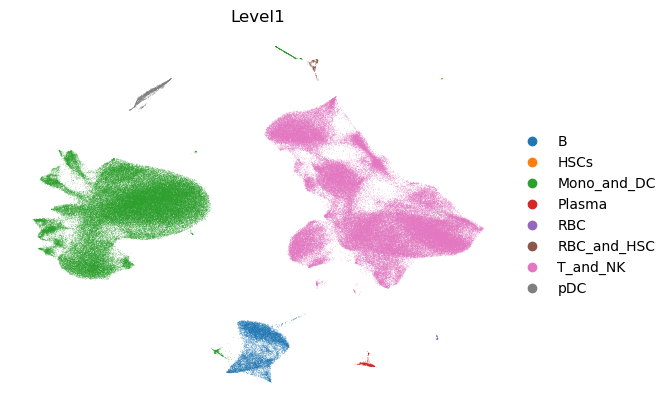

In [10]:
# 8ter. Aplicamos el mapeo a obs["leiden_L1"] y filtramos Platelets si existen

clusters_str = adata.obs["leiden_L1"].astype(str)

# Comprobamos que todos los clusters tienen asignación en LEVEL1_MAP
missing_keys = set(clusters_str.unique()) - set(LEVEL1_MAP.keys())
if missing_keys:
    raise KeyError(
        f"Faltan asignaciones para los siguientes clusters en LEVEL1_MAP: {missing_keys}\n"
        "Revisa LEVEL1_MAP (incluyendo ajustes manuales de la celda 8bis)."
    )

# Asignamos Level1 según LEVEL1_MAP (ya modificado en la celda 8bis)
adata.obs["Level1"] = clusters_str.map(LEVEL1_MAP)
adata.obs["Level1"] = adata.obs["Level1"].astype("category")

print("\nDistribución de Level1 antes de filtrar plaquetas (si las hubiera):")
print(adata.obs["Level1"].value_counts())

# --------------------------------------------------------
# Eliminación inmediata de plaquetas a petición de la tutora
# --------------------------------------------------------
if "Platelets" in adata.obs["Level1"].cat.categories:
    plate_mask = adata.obs["Level1"] == "Platelets"
    n_platelets = int(plate_mask.sum())
    print(f"\n[INFO] Células con Level1 = 'Platelets': {n_platelets}")

    if n_platelets > 0:
        print(f"[INFO] Eliminando {n_platelets} células con Level1 = 'Platelets' (decisión biológica).")
        # Subseteamos el objeto para eliminar plaquetas del análisis posterior
        adata = adata[~plate_mask].copy()

        # Aseguramos tipo categórico y limpiamos categorías no usadas (incluida 'Platelets')
        if isinstance(adata.obs["Level1"].dtype, pd.CategoricalDtype):
            adata.obs["Level1"] = adata.obs["Level1"].cat.remove_unused_categories()
else:
    print("\nNo hay categoría 'Platelets' en Level1; no se filtra nada.")

print("\nDistribución final de Level1 tras filtrar plaquetas (si las había):")
print(adata.obs["Level1"].value_counts())

# UMAP coloreado por Level1 definitivo
sc.pl.embedding(
    adata,
    basis=CONFIG["UMAP_KEY"],
    color=["Level1"],
    frameon=False,
)


Añadimos la parte que aplica el mapeo:

- Se ejecuta `scanpy.tl.rank_genes_groups` con:
  - `groupby = "Level1"`,
  - método `wilcoxon`,
  - `use_raw=False` (usa `adata.X = log1p_10k`),
  - `pts=True` (porcentaje de células que expresan cada gen).
- Resultado:
  - `adata.uns["rank_genes_Level1"]` contiene marcadores 1-vs-rest por linaje,
  - con `scores`, `pvals`, `pvals_adj`, `logfoldchanges`, `pts`, `pts_rest`.
- Se genera una figura resumen con `sc.pl.rank_genes_groups`
  (por defecto, top 20 genes por linaje).

In [11]:
# 8bis. DE global 1-vs-rest por Level1 (marcadores de linaje)

GROUPBY_KEY = "Level1"
RANKGENES_KEY = "rank_genes_Level1"

if GROUPBY_KEY not in adata.obs.columns:
    raise KeyError(
        f"No se encontró '{GROUPBY_KEY}' en adata.obs. "
        "Asegúrate de haber definido obs['Level1'] en la celda anterior."
    )

print(
    f"Calculando marcadores 1-vs-rest por Level1 usando scanpy.tl.rank_genes_groups "
    f"(groupby = '{GROUPBY_KEY}', method = 'wilcoxon')..."
)

sc.tl.rank_genes_groups(
    adata,
    groupby=GROUPBY_KEY,
    method="wilcoxon",
    use_raw=False,   # usamos la matriz actual (adata.X = log1p_10k)
    n_genes=None,    # todos los genes
    pts=True,        # porcentaje de células que expresan el gen en el grupo/resto
    key_added=RANKGENES_KEY,
)

print(f"Resultados almacenados en adata.uns['{RANKGENES_KEY}'].")

Calculando marcadores 1-vs-rest por Level1 usando scanpy.tl.rank_genes_groups (groupby = 'Level1', method = 'wilcoxon')...
Resultados almacenados en adata.uns['rank_genes_Level1'].


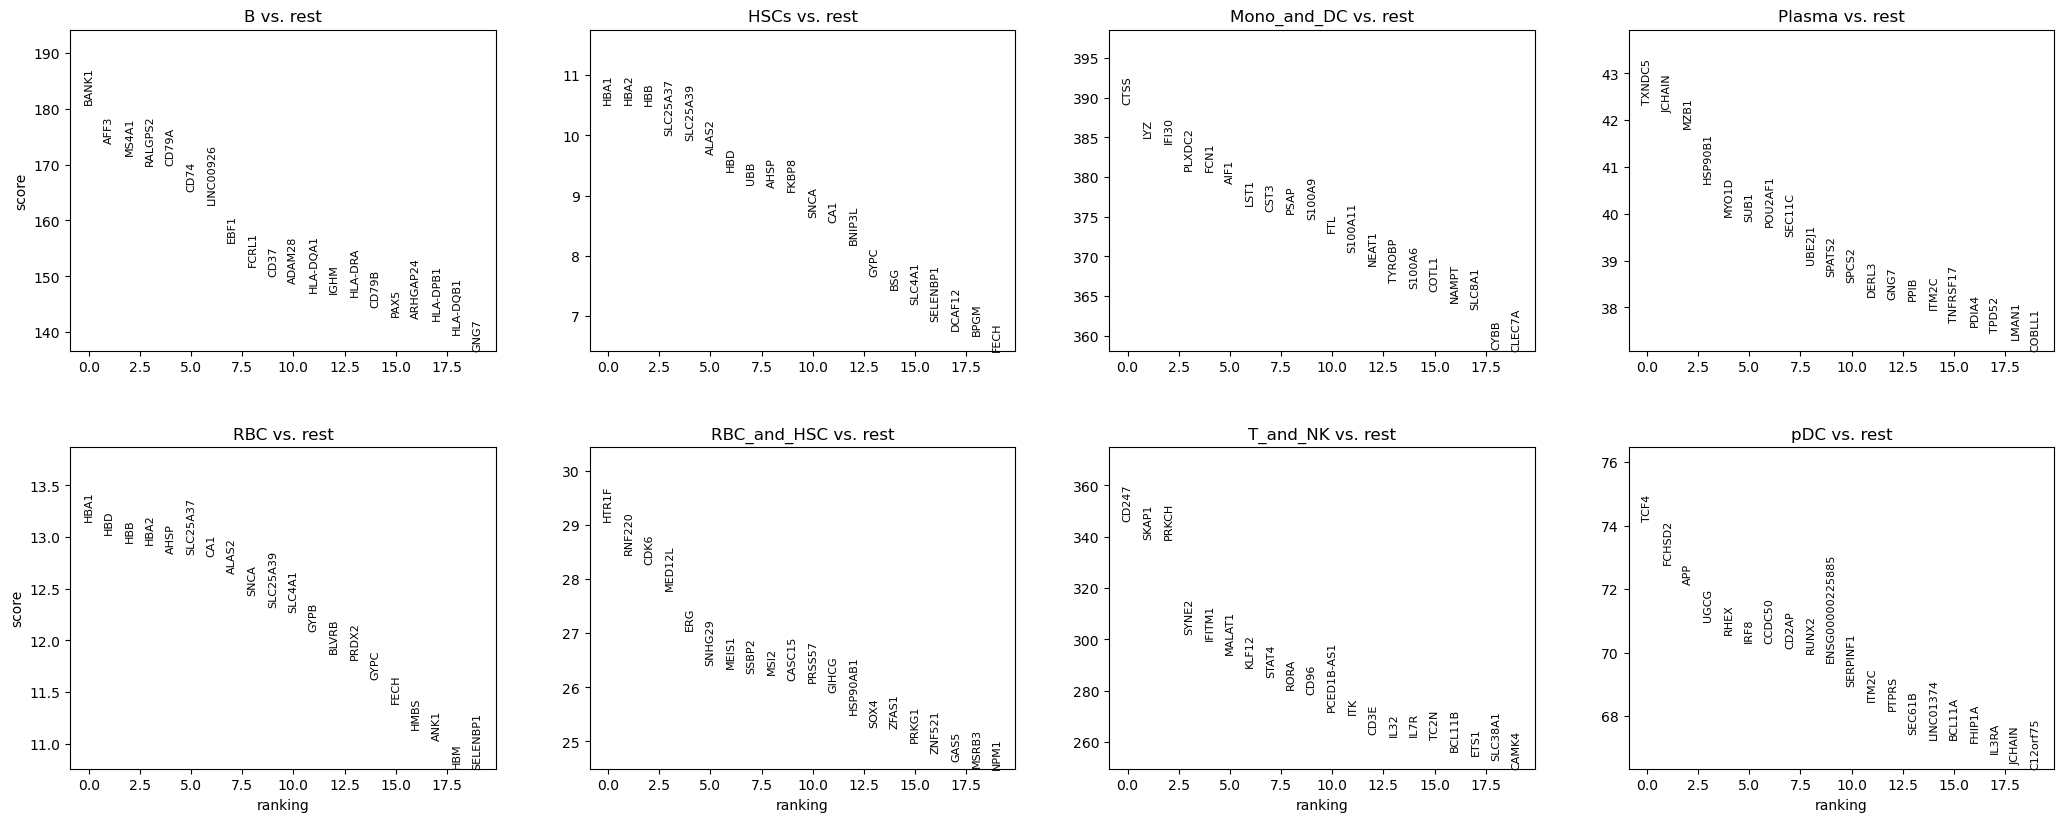

In [12]:
sc.pl.rank_genes_groups(
    adata,
    key=RANKGENES_KEY,
    n_genes=20,
    sharey=False,
)

- Se define `rank_genes_to_long_df(...)` para convertir
  `adata.uns["rank_genes_Level1"]` en un **DataFrame largo** con columnas:

  - `Level1` (o `groupby`),
  - `gene`,
  - `scores`, `pvals`, `pvals_adj`,
  - `logfoldchanges`,
  - `pct_in_group`, `pct_out_group`,
  - `rank`.

- Se guarda la tabla en:

  - `data_processed/TFM_CIRRHOSIS_Level1_markers_rank_genes.csv`.

- Esta tabla resume los marcadores de Level1 que justifican la anotación.

In [13]:
# 8ter. Conversión de resultados DE Level1 a DataFrame largo y guardado en .csv

def rank_genes_to_long_df(adata, key: str, groupby: str) -> pd.DataFrame:
    """
    Convierte los resultados de scanpy.tl.rank_genes_groups (en adata.uns[key])
    a un DataFrame en formato largo, con columnas:
        groupby, cluster, gene, scores, pvals, pvals_adj,
        logfoldchanges (si existe), pct_in_group (pts), pct_out_group (pts_rest), rank
    """
    rg = adata.uns[key]
    groups = rg["names"].dtype.names  # nombres de grupos (aquí, categorías de Level1)

    records = []
    for group in groups:
        names = rg["names"][group]
        scores = rg["scores"][group]
        pvals = rg["pvals"][group]
        pvals_adj = rg["pvals_adj"][group]

        # Algunos métodos devuelven logfoldchanges; otros no
        logfoldchanges = rg.get("logfoldchanges", None)
        if logfoldchanges is not None:
            lfc = logfoldchanges[group]
        else:
            lfc = [np.nan] * len(names)

        # Porcentaje de células que expresan el gen en grupo/resto (si está disponible)
        pts = rg.get("pts", None)
        if pts is not None:
            pct_in = pts[group]
        else:
            pct_in = [np.nan] * len(names)

        pts_rest = rg.get("pts_rest", None)
        if pts_rest is not None:
            pct_out = pts_rest[group]
        else:
            pct_out = [np.nan] * len(names)

        for rank, (gene, s, pv, pva, lf, pi, po) in enumerate(
            zip(names, scores, pvals, pvals_adj, lfc, pct_in, pct_out), start=1
        ):
            records.append({
                groupby: group,
                "cluster": group,  # aquí group == categoría de Level1
                "gene": gene,
                "scores": s,
                "pvals": pv,
                "pvals_adj": pva,
                "logfoldchanges": lf,
                "pct_in_group": pi,
                "pct_out_group": po,
                "rank": rank,
            })

    df = pd.DataFrame.from_records(records)
    return df


LEVEL1_DE_KEY = "rank_genes_Level1"   # mismo nombre que RANKGENES_KEY
GROUPBY_KEY = "Level1"

markers_L1_df = rank_genes_to_long_df(adata, key=LEVEL1_DE_KEY, groupby=GROUPBY_KEY)
print(markers_L1_df.head())

# Ruta de salida para la tabla de marcadores de Level1
l1_markers_csv_path = CONFIG["DATA_PROCESSED_DIR"] / "TFM_CIRRHOSIS_Level1_markers_rank_genes.csv"

markers_L1_df.to_csv(l1_markers_csv_path, index=False)
print("\nTabla de marcadores de Level1 guardada en formato .csv en:")
print(l1_markers_csv_path)

  Level1 cluster     gene      scores  pvals  pvals_adj  logfoldchanges  \
0      B       B    BANK1  180.938766    0.0        0.0        8.608594   
1      B       B     AFF3  173.812607    0.0        0.0        6.395173   
2      B       B    MS4A1  171.770065    0.0        0.0        8.733736   
3      B       B  RALGPS2  169.951553    0.0        0.0        5.597907   
4      B       B    CD79A  169.899872    0.0        0.0        8.100095   

   pct_in_group  pct_out_group  rank  
0           0.0       0.000010     1  
1           0.0       0.000005     2  
2           0.0       0.000005     3  
3           0.0       0.000000     4  
4           0.0       0.000010     5  

Tabla de marcadores de Level1 guardada en formato .csv en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_Level1_markers_rank_genes.csv


## 9. División del objeto por linaje Level1

- Se listan las categorías presentes en `obs["Level1"]`.
- Para cada linaje con células:

  - se crea un sub-objeto `adata_l1 = adata[Level1 == l1].copy()`,
  - se guarda en `data_processed/lineages/TFM_CIRRHOSIS_Level1_<LINAGE>.h5ad`
    (espacios reemplazados por `_`).

- Estos objetos serán la entrada de los notebooks de Level2 (uno por linaje),
  donde se hará:
  - QC refinado,
  - PCA/Harmony/UMAP locales,
  - clustering y anotación de subtipos.

In [14]:
# 9. División del objeto por linaje Level1

# Aseguramos que existe la carpeta de salida
LINEAGES_DIR.mkdir(parents=True, exist_ok=True)

level1_categories = list(adata.obs["Level1"].cat.categories)
print("Linajes Level1 presentes en el objeto (tras filtrado de plaquetas):")
print(level1_categories)

# Por seguridad, no generamos objetos para Platelets aunque algún residuo quedase
EXCLUDE_L1_FOR_SPLIT = ["Platelets"]

for l1 in level1_categories:
    if l1 in EXCLUDE_L1_FOR_SPLIT:
        print(f"Saltando linaje '{l1}' (excluido por decisión biológica).")
        continue

    # Máscara de células de este linaje
    mask = (adata.obs["Level1"] == l1).values
    n_cells = int(mask.sum())
    if n_cells == 0:
        print(f"Saltando linaje '{l1}' porque no tiene células.")
        continue

    adata_l1 = adata[mask].copy()

    safe_l1 = l1.replace(" ", "_")
    out_path = LINEAGES_DIR / f"TFM_CIRRHOSIS_Level1_{safe_l1}.h5ad"

    adata_l1.write_h5ad(out_path)
    print(f"Guardado linaje '{l1}' ({n_cells} células) en: {out_path}")

Linajes Level1 presentes en el objeto (tras filtrado de plaquetas):
['B', 'HSCs', 'Mono_and_DC', 'Plasma', 'RBC', 'RBC_and_HSC', 'T_and_NK', 'pDC']
Guardado linaje 'B' (12110 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_B.h5ad
Guardado linaje 'HSCs' (39 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_HSCs.h5ad
Guardado linaje 'Mono_and_DC' (88902 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_Mono_and_DC.h5ad
Guardado linaje 'Plasma' (608 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_Plasma.h5ad
Guardado linaje 'RBC' (84 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_RBC.h5ad
Guardado linaje 'RBC_and_HSC' (344 células) en: D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\lineages\TFM_CIRRHOSIS_Level1_RBC_and_HSC.h5ad
Guardado linaje 'T_and

## 10. Guardado del objeto principal con Level1 anotado

- Además de los archivos por linaje, se guarda el objeto global con:

  - embedding Harmony (`obsm[EMB_KEY]`),
  - vecinos (`uns[NBR_KEY]`),
  - UMAP integrado (`obsm[UMAP_KEY]`),
  - clusterings Leiden (`obs["leiden_*"]`),
  - anotación de `obs["Level1"]`,
  - (opcional) `obs["Level1_auto_suggested"]`,
  - resultados de DE Level1 (`uns["rank_genes_Level1"]`).

- Ruta de salida:

  - `data_processed/TFM_CIRRHOSIS_main_with_Level1.h5ad`.

In [15]:
# 10. Guardado del objeto principal con Level1 anotado

main_with_l1_path = DATA_PROCESSED_DIR / "TFM_CIRRHOSIS_main_with_Level1.h5ad"
adata.write_h5ad(main_with_l1_path)

print("Objeto principal con Level1 anotado guardado en:")
print(main_with_l1_path)

Objeto principal con Level1 anotado guardado en:
D:\Users\Coni\Documents\TFM_CirrhosIS\data_processed\TFM_CIRRHOSIS_main_with_Level1.h5ad


## 11. Resumen de este notebook

- Entrada:
  - `TFM_CIRRHOSIS_harmony_neighbors_umap.h5ad` con Harmony, vecinos,
    UMAP y clustering global `leiden_L1`.
- Pasos clave:
  - importación de paneles `geneMarkers_level1` desde `markers.py`,
  - construcción de `varnames_level1` con genes realmente presentes,
  - dotplots de marcadores por cluster global,
  - sugerencia automática de Level1 por cluster (excluyendo UTC del scoring),
  - construcción de `LEVEL1_MAP` (cluster → Level1) a partir de esa sugerencia,
  - asignación final de `obs["Level1"]` y visualización en UMAP,
  - DE 1-vs-rest por Level1 y exportación de marcadores a `.csv`,
  - división del objeto en archivos por linaje,
  - guardado del objeto global anotado.

- Salidas principales:
  - `data_processed/TFM_CIRRHOSIS_main_with_Level1.h5ad` → objeto global anotado.
  - `data_processed/lineages/TFM_CIRRHOSIS_Level1_<LINAGE>.h5ad` → un archivo por linaje.
  - `data_processed/TFM_CIRRHOSIS_Level1_markers_rank_genes.csv` → tabla de marcadores.

- Notas sobre UTC:
  - Conceptualmente, `UTC` agrupa MAIT + γδT (unconventional T).
  - Técnicamente, en Level1 todas las células T (convencionales y “unconventional”)
    se agrupan en `T_and_NK` y `UTC` se reserva como categoría de fallback.
  - En este dataset, todos los clusters muestran un linaje clásico claro
    y ninguno queda anotado como `UTC` en Level1.
  - Los subtipos MAIT y γδT se identifican más adelante en Level2 dentro de `T_and_NK`.

### Nota de cambios tras retroalimentación de la tutora (Notebook 06)

- **Separación RBC / HSCs ya en Level1**  
  - Clúster 22 → `RBC`  
  - Clúster 23–24 → `HSCs`  
  - Se definen como linajes Level1 distintos (no se agrupan en `RBC_and_HSC`).

- **Plaquetas eliminadas en Level1**  
  - El clúster identificado como plaquetas (`Platelets`) se filtra del objeto global en este notebook.  
  - A partir de aquí, el dataset principal **no contiene plaquetas** para el downstream.

- **pDC y Plasma como linajes Level1 finales**  
  - `pDC` y `Plasma` se mantienen como linajes Level1 propios y **no tendrán Level2** en notebooks posteriores (la tutora indica que son poblaciones únicas).

- **LEVEL1_MAP ajustado y aplicado**  
  - Se mantiene la asignación semi-automática basada en paneles de marcadores de `markers.py`,  
    pero se fuerza manualmente: `RBC`, `HSCs` y `Platelets` según la decisión de la tutora.

- **DE global por Level1 actualizado**  
  - Marcadores 1-vs-rest recalculados tras el nuevo Level1 (sin plaquetas y con `RBC` / `HSCs` separados).  
  - Resultados guardados en `TFM_CIRRHOSIS_Level1_markers_rank_genes.csv`.

- **Objeto global actualizado para downstream**  
  - Se guarda `TFM_CIRRHOSIS_main_with_Level1.h5ad` ya sin plaquetas  
    y con las categorías de Level1 finales: `T_and_NK`, `B`, `Mono_and_DC`, `Plasma`, `pDC`, `RBC`, `HSCs`.